In [7]:
import numpy as np
import matplotlib.pyplot as plt
from beauty import get_axes

# Active Learning Classifier

Notebook going over the main utilities and functions of the Active Learning classifier

## Reference data set

In [8]:
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data,
                  columns=iris.feature_names,
                  )
df['Species'] = iris.target
target_names = {
    0 : 'setosa',
    1 : 'versicolor',
    2 : 'virginica'
}
df['Species'] = df['Species'].map(target_names)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   Species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


1. The `DataLoader()` class can be used to load and select the fratures of interest for the AL experiment.

In [9]:
from datamanager import DataLoader

data_dict = {
    'target_feature' : 'Species',
    'used_features' : ['petal length (cm)','petal width (cm)']
}

data = DataLoader(df=df, **data_dict)

Loading DataFrame ...

Target feature: Species
Changing categorical values to classes.
Categories mapped to {'setosa': 0, 'versicolor': 1, 'virginica': 2}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   petal length (cm)  150 non-null    float64
 1   petal width (cm)   150 non-null    float64
dtypes: float64(2)
memory usage: 2.5 KB
Working DataFrame: None


2. In this example we will split the dataset as usual into `train` and `test` so that we can test out model. The `train` part of the dataset will be used as the _pool_ of candidates points where the AL experiment can choose from.

In [10]:
test_split_size = .6

X_train, X_test, y_train, y_test = data.data_splits(test_size=test_split_size)

X_train.shape, X_test.shape

((60, 2), (90, 2))

In [11]:
X_train.head()

,petal length (cm),petal width (cm)
0,5.1,1.5
1,6.4,2.0
2,1.4,0.2
3,1.7,0.4
4,1.6,0.4


**Possible issues to be addressed**:
-   Where/How to introduce the concept of Dimensionality Reduction, for visualization and/or for the AL selection.
-   ...

## _AL experiment_ breakdown

The Active Learning Classifier is built by 2 fundamental steps:

1. **Classification**: the model chosen to classify the initial starting data points (_e.g._, GP classifier, SV classifier, etc.);
2. **Acquisition**: the mode in which new points are selected (_e.g._, expoitation, exploration, random)

Following these two steps the AL-classifier takes in input the initial batch of points and outputs, for every cycle, a new batch of points that are regarded as "interesting".


### Classification

The current AL-classifier supports only two classifier algorithm:
-   GP
-   SV

In [12]:
from classification import *


clf_model = 'GaussianProcessClassifier'

clf_dict = dict(
    kernel=1.0 * RBF(1.0), 
    random_state=73
)

In [13]:
oneshot_clf = ClassifierModel(model=clf_model, **clf_dict)

We can visualise how the model work by fitting the training set in a "one-shot" manner.

In [14]:
# `idxs=None` makes the class select all the available points

oneshot_clf.fit(X_train, y_train, idxs=None)

In [15]:
from beauty import plot_classification

In [16]:
f0, f1 = data_dict['used_features']
X0, X1 = X_train[f0], X_train[f1]

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


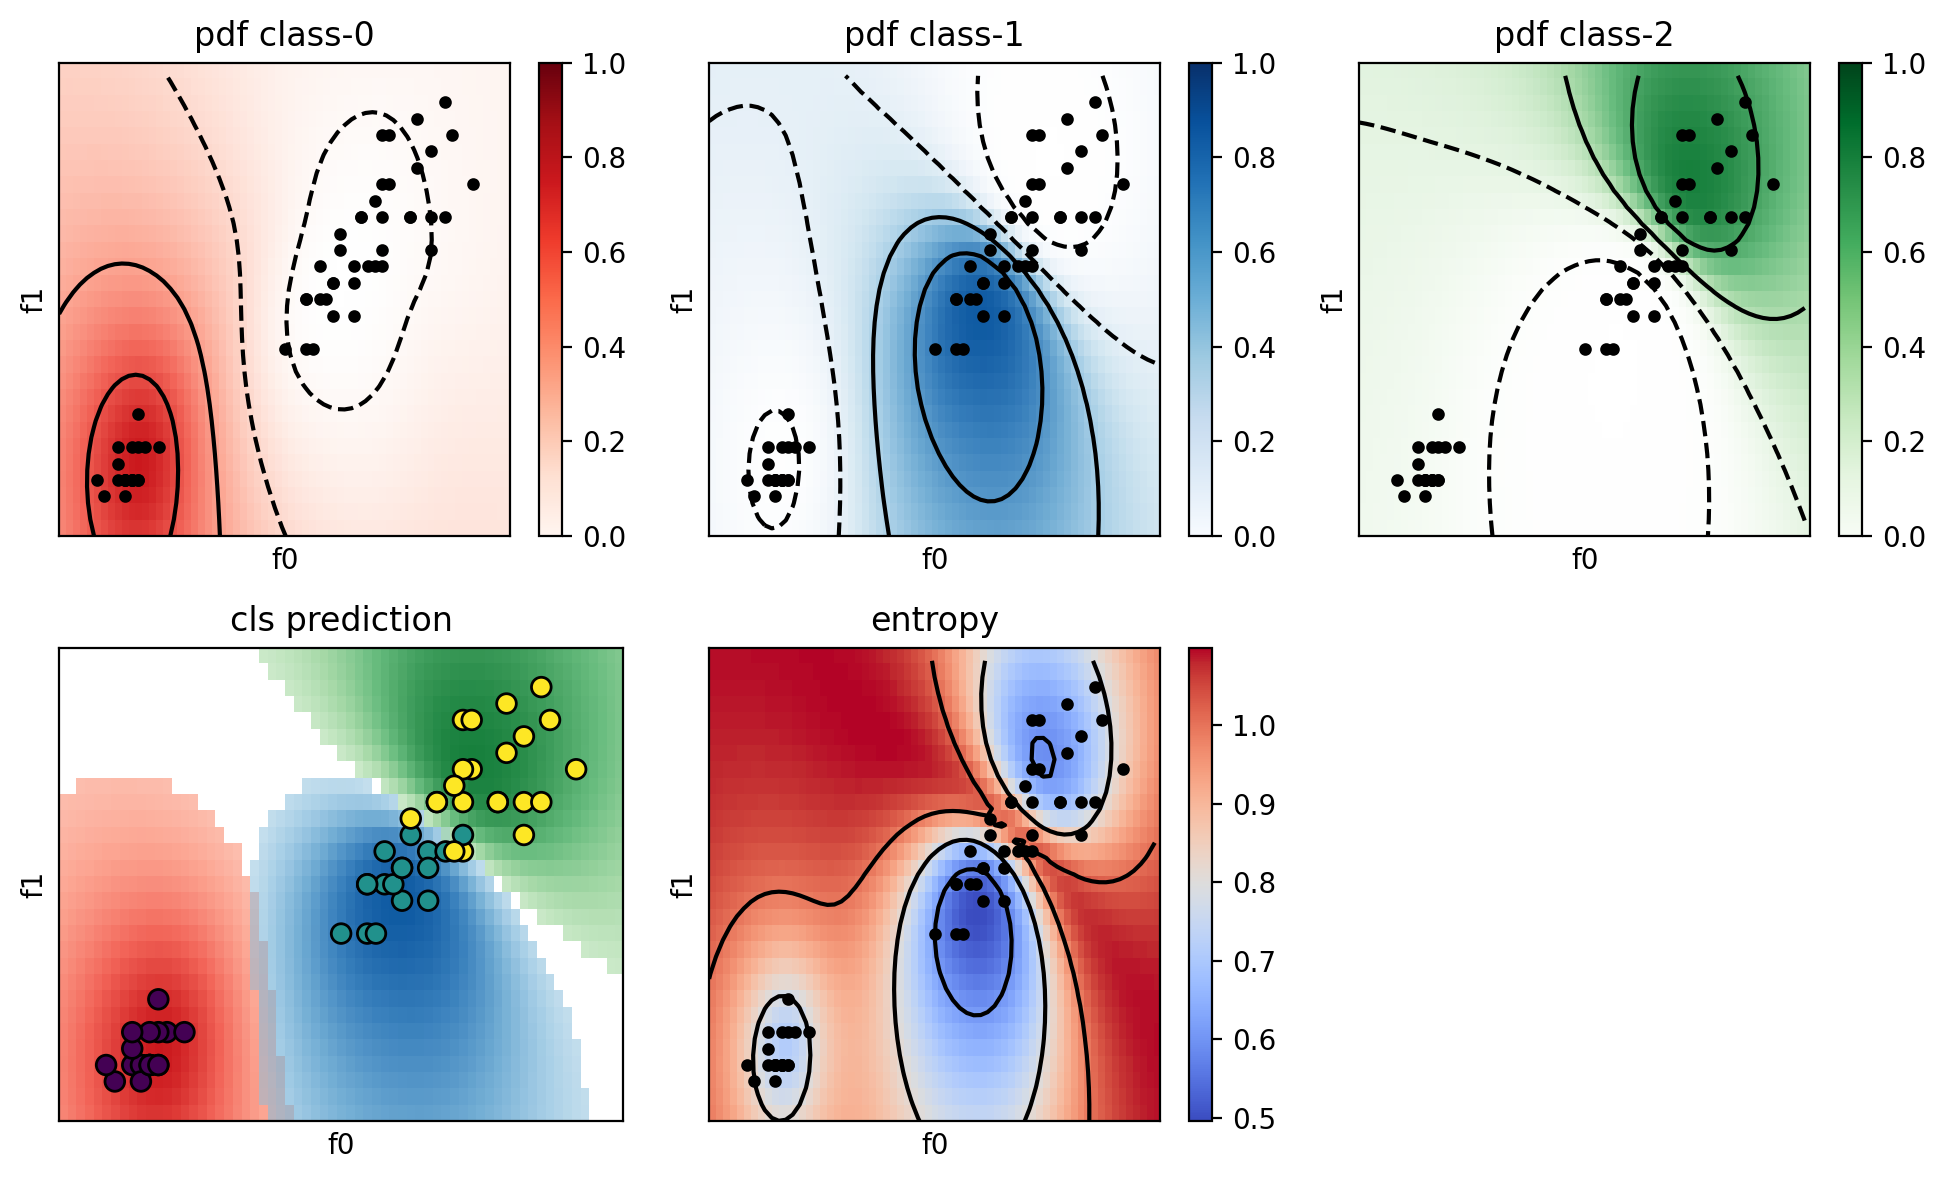

In [17]:
plot_classification(feature_space=(X0, X1, y_train), clfModel=oneshot_clf)

### Acquisition

...

In [18]:
import scipy
from misc import get_space_lims, make_meshgrid

from acquisition import DecisionFunction

First, we create a dummy frature space, to visualize how the Entropy-space looks like and how the selection methods works (same as the function `plot_classification()` does for plotting the results).

In [19]:
incr = '10%'
x_min, x_max = get_space_lims(coord=X0, incr=incr)
y_min, y_max = get_space_lims(coord=X1, incr=incr)
xx, yy = make_meshgrid(x=X0, y=X1, incr=incr, delta=.2)

Second, we compute the PDF and the Entropy function, since most of the acquisition methods are based on the latter.

In [20]:
pdf = oneshot_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
H = scipy.stats.entropy(pk=pdf, axis=1)
Z = pdf.reshape((xx.shape[0], xx.shape[1], -1))

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


In [21]:
# retrieve the position of the indiviadual cells

positions = np.vstack([xx.ravel(), yy.ravel()])

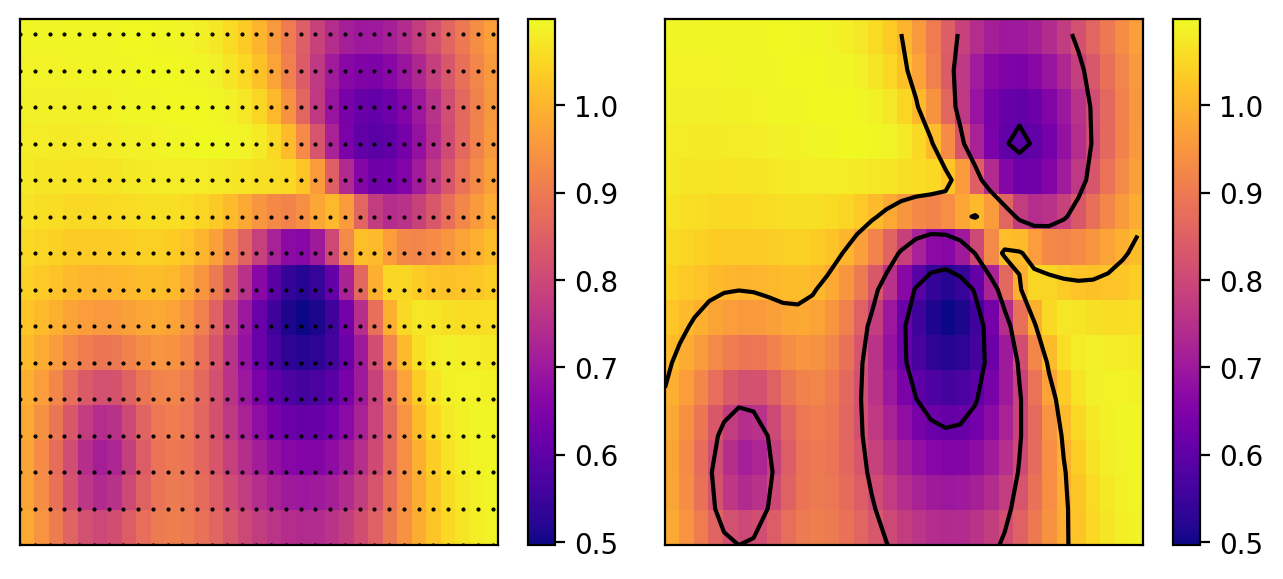

In [22]:
fig, ax = get_axes(2,2)

ax[0].scatter(positions[0], positions[1], marker='.', s=1, c='0.')

surf = ax[0].imshow(H.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max),
             cmap='plasma',
             origin="lower", aspect='auto')
cbar = fig.colorbar(surf,ax=ax[0])

surf1 = ax[1].imshow(H.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max),
             cmap='plasma',
             origin="lower", aspect='auto')
cbar1 = fig.colorbar(surf1, ax=ax[1])

ax[1].contour(xx, yy, H.reshape(xx.shape), levels=3, colors='0.', norm='linear', zorder=4)

for i in range(2):
    ax[i].set_xticks(())
    ax[i].set_yticks(())

fig.tight_layout()

In [23]:
Nacqui = 10

In [24]:
points_idx = np.arange(positions.shape[1])
points_idx[:5]

array([0, 1, 2, 3, 4])

Now we will generate new points, based on the dummy feature space that we have created.

1. **Random acquisition**: just selects N points randomly from the one available.

In [25]:
acqui_rng = DecisionFunction(mode='random', seed=42).acquire(idxs=points_idx, n=Nacqui)
len(acqui_rng)

10

2. **Exploration**: based on the concept of _highest_ entropy, it selects N points that have the highest entropy values, _aka_ samples the most unkown areas of the currently trained model.

In [26]:
acqui_exploration = DecisionFunction(mode='exploration', seed=42).acquire(pdf=pdf, n=Nacqui)
len(acqui_exploration)

10

3. **Exploitation**: based on the opposite concept (of _exploration_), it selects N points that have the lowest entropy values, _aka_ samples the least unkown areas of the currently trained model.

In [27]:
acqui_exploitation = DecisionFunction(mode='exploitation', seed=42).acquire(pdf=pdf, n=Nacqui)
len(acqui_exploitation)

10

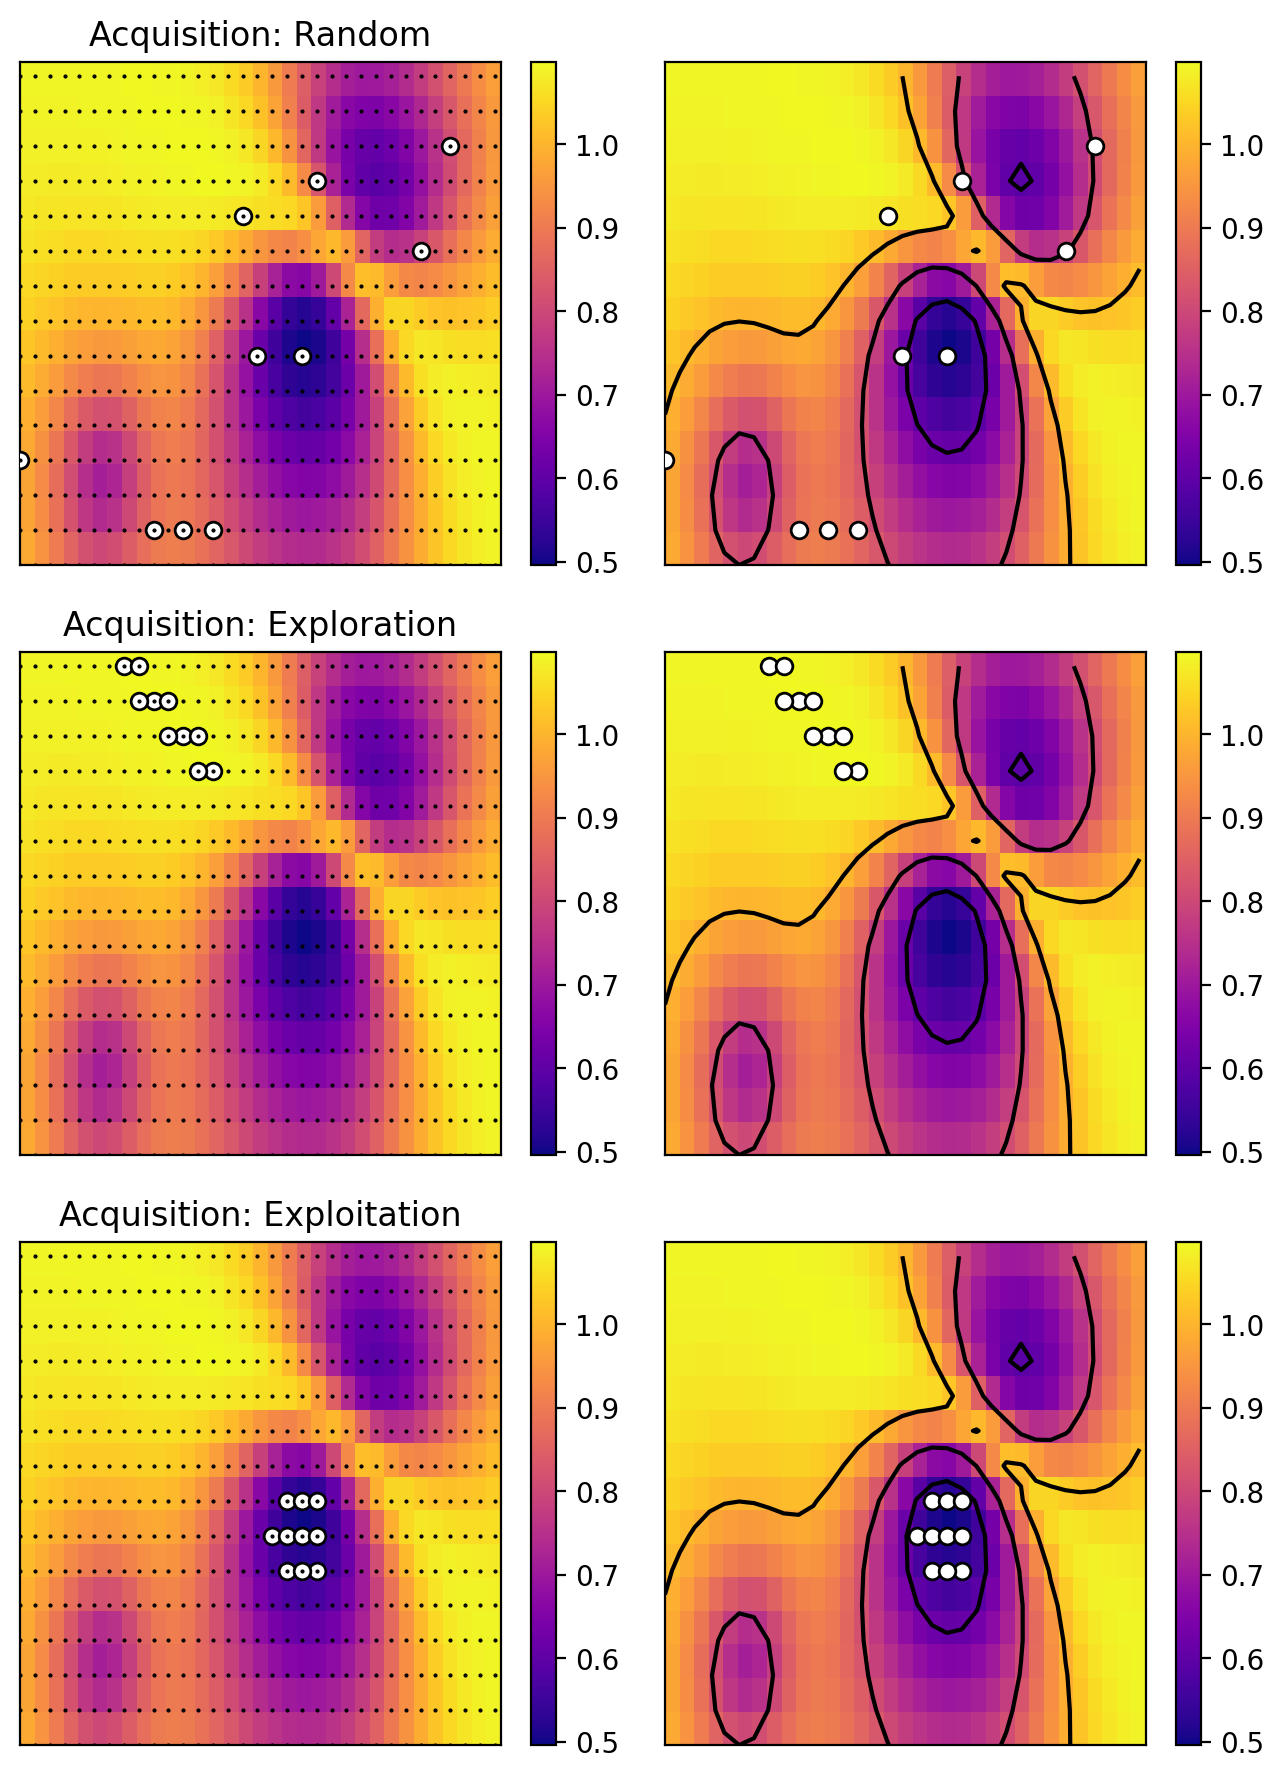

In [28]:
acquisition_modes = {
    'Random' : acqui_rng,
    'Exploration' : acqui_exploration,
    'Exploitation' : acqui_exploitation
}

fig, ax = get_axes(2*3,2)

for i,(k,v) in enumerate(acquisition_modes.items()):

    ax[i*2].scatter(positions[0], positions[1], marker='.', s=1, c='0.', zorder=5)
    ax[i*2].scatter(positions[0,v], positions[1,v], c='1.', edgecolor='0.', zorder=4)
    surf = ax[i*2].imshow(H.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max),
                cmap='plasma',
                origin="lower", aspect='auto')
    cbar = fig.colorbar(surf,ax=ax[i*2])
    ax[i*2].set_title(f"Acquisition: {k}")

    ax[i*2+1].scatter(positions[0,v], positions[1,v], c='1.', edgecolor='0.', zorder=4)
    surf1 = ax[i*2+1].imshow(H.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max),
                cmap='plasma',
                origin="lower", aspect='auto')
    cbar1 = fig.colorbar(surf1, ax=ax[i*2+1])
    ax[i*2+1].contour(xx, yy, H.reshape(xx.shape), levels=3, colors='0.', norm='linear', zorder=3)


for i in range(3*2):
    ax[i].set_xticks(())
    ax[i].set_yticks(())

fig.tight_layout()

## Active learning Cycle

Using the `X_train` dataset we will begin the Active Learnig experiment.

The AL cycle follows the following steps:
1. A starting batch of point is selected
2. The classifier is trained using only this inital batch (usually very few points) (_cycle 0_)
3. Based on the knowledge just ontained we estimate how new points should be selected for the new cycles.
4. Acquisition of new points based on some rules.
5. Retraining the algorithm on the new acquired points.

The function `get_starting_batch` just select a random selection of indexes.

In [29]:
from learning import get_starting_batch

# start_idxs = get_starting_batch(data=X_train, init_batch=2)
start_idxs = [49, 40]
print(start_idxs)

[49, 40]


The classifier can be setup like before using the specific class.

In [30]:
from classification import *

# name as defined in the class
clf_model = 'GaussianProcessClassifier'

# specific parameters
clf_dict = dict(
    kernel=1.0 * RBF(1.0), 
    random_state=73
)

al_clf = ClassifierModel(model=clf_model, **clf_dict)

It is possible to access the actual classifier by the `.clf` property of the class.

In [31]:
al_clf.clf

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1), random_state=73)

The acquisiton of future points can be setup using the specific class as well.

In [32]:
from acquisition import DecisionFunction

acqui_mode = 'exploration'

ac_func = DecisionFunction(mode=acqui_mode)

### ActiveClf: Single cycle

The function `active_learning_cycle` performs a single cycle of AL and outputs the new candidates for the next cycle.

In "real-life" scenarios these new candidates have to probably tested in the lab to get the the response out of it, but for this example we will only refer to the training dataset we have selected.

While searching for new candidates, especially in the earlier stages, it may happen that there are many points that fall into the same acquisition criteria.
In this case we can sample only a few of them, the `new_batch`, by using two different methods:
1. **Random** sampling: select randomly amongst the acquired pool of points.
2. **FPS** Farthest Point Sampling: which selects points in a MinMax fashion, which is more likely to span the diversity of the acquired pool of points.

In [33]:
from learning import active_learning_cycle

In [34]:
new_idxs_nosel = active_learning_cycle(
    feature_space=(X_train, y_train),   # starting training feature space (points, classes)
    idxs=start_idxs,                    # starting indexes
    new_batch=5,                        # number of points in outcome
    clfModel=al_clf,                    # initialised classifier
    acquisitionFunc=ac_func,            # aquisition mode
    screeningSelection=None             # sampling methods for the points acquisition
    )
new_idxs_nosel

[2,
 3,
 4,
 5,
 8,
 9,
 10,
 15,
 16,
 17,
 21,
 24,
 25,
 30,
 31,
 32,
 33,
 37,
 38,
 42,
 47,
 48,
 57]

#### Random sampling

In [35]:
new_idxs_rng = active_learning_cycle(
    feature_space=(X_train, y_train),   # starting training feature space (points, classes)
    idxs=start_idxs,                    # starting indexes
    new_batch=5,                        # number of points in outcome
    clfModel=al_clf,                    # initialised classifier
    acquisitionFunc=ac_func,            # aquisition mode
    screeningSelection='random'         # sampling methods for the points acquisition
    )
new_idxs_rng

Found 23 points that shares the same acquisition criteria.
Selecting 5 by 'random' sampling.


[5, 24, 2, 31, 37]

We can use the `plot_active_learning_cycle()` function to plot the per-cycle results.

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


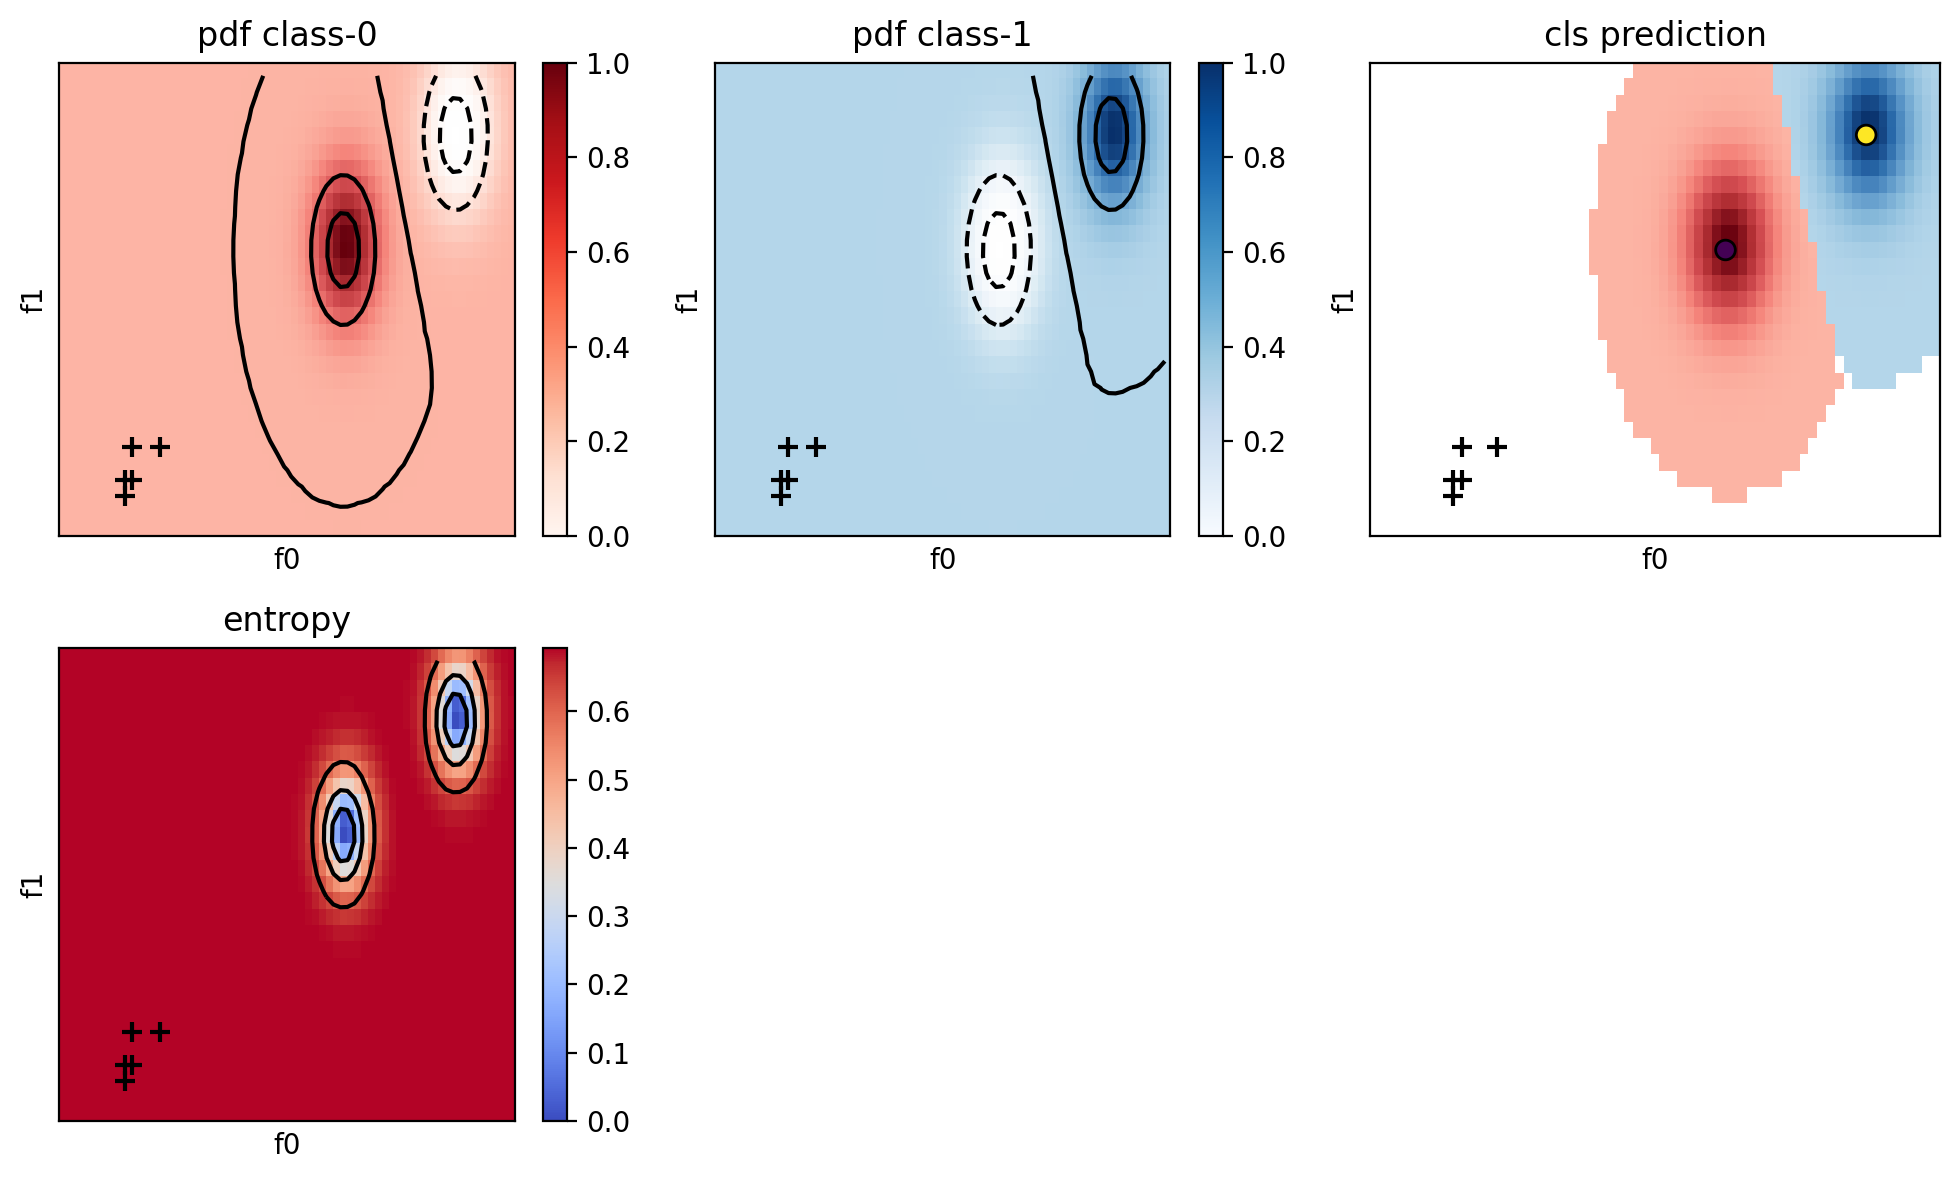

In [36]:
from beauty import plot_active_learning_cycle

plot_active_learning_cycle(
    feature_space=(X0,X1,y_train),  # feature space (only for visualisation)
    clfModel=al_clf,                # fit classifier
    idxs=start_idxs,                # start indexes
    new_idxs=new_idxs_rng           # output indexes from the AL-clf cycle
    )

#### FPS

In [37]:
new_idxs_fps = active_learning_cycle(
    feature_space=(X_train, y_train),   # starting training feature space (points, classes)
    idxs=start_idxs,                    # starting indexes
    new_batch=5,                        # number of points in outcome
    clfModel=al_clf,                    # initialised classifier
    acquisitionFunc=ac_func,            # aquisition mode
    screeningSelection='FPS'            # sampling methods for the points acquisition
    )
new_idxs_fps

Found 23 points that shares the same acquisition criteria.
Selecting 5 by 'FPS' sampling.


[3, 42, 21, 17, 31]

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


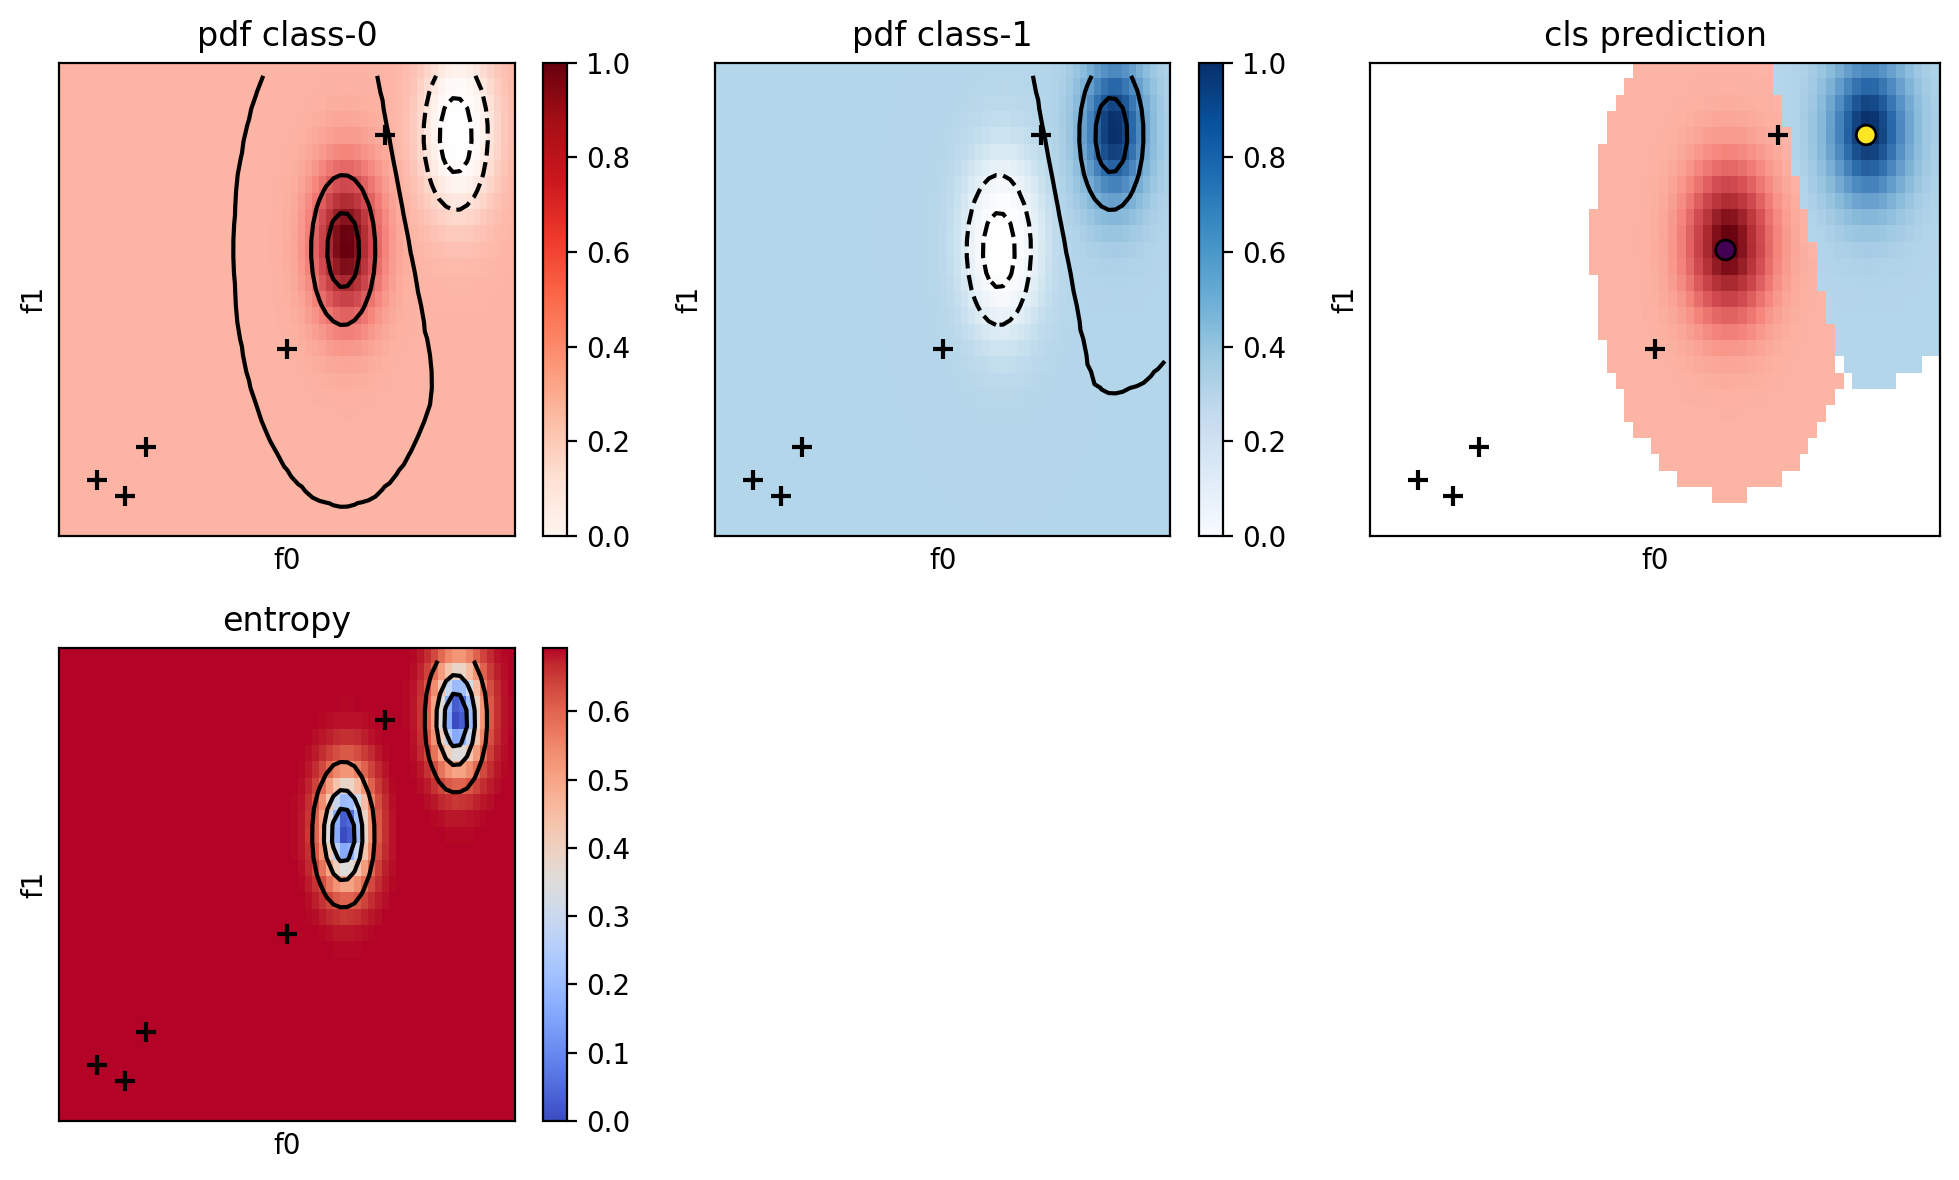

In [38]:
plot_active_learning_cycle(
    feature_space=(X0,X1,y_train),  # feature space (only for visualisation)
    clfModel=al_clf,                # fit classifier
    idxs=start_idxs,                # start indexes
    new_idxs=new_idxs_fps           # output indexes from the AL-clf cycle
    )

### Comparison between sampling methods

In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
incr = '10%'
x_min, x_max = get_space_lims(coord=X0, incr=incr)
y_min, y_max = get_space_lims(coord=X1, incr=incr)
xx, yy = make_meshgrid(x=X0, y=X1, incr=incr, delta=.1)

Z = al_clf.predict_proba(X=np.c_[xx.ravel(), yy.ravel()])
Z = MinMaxScaler().fit_transform(X=Z)
H = scipy.stats.entropy(pk=Z, axis=1)

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


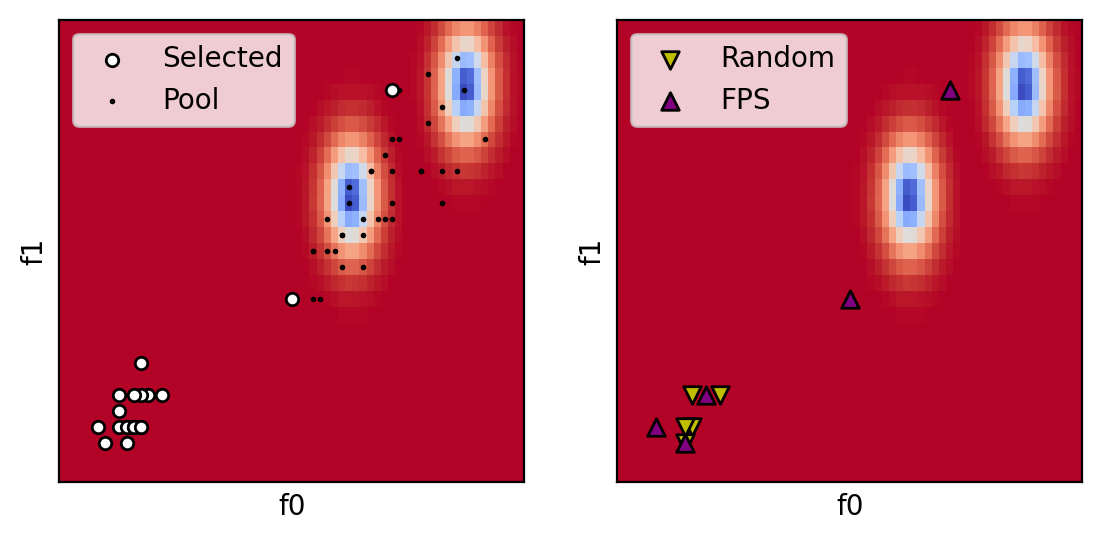

In [41]:
fig, ax = get_axes(2,2)

ax[0].scatter(X0[new_idxs_nosel], X1[new_idxs_nosel], c='1.', 
              edgecolor='0.', s=20, zorder=4, label='Selected')
ax[0].scatter(X0, X1, c='0.', edgecolor='0.', s=1, zorder=3, label='Pool')
surf = ax[0].imshow(H.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max),
                    cmap='coolwarm', alpha=1.,
                    origin="lower", aspect='auto')

# ax[1].scatter(X0[new_idxs_nosel], X1[new_idxs_nosel], c='1.', 
#               edgecolor='0.', s=20, zorder=4, label='Selected')
ax[1].scatter(X0[new_idxs_rng], X1[new_idxs_rng], c='y', edgecolor='0.',
              marker='v', s=40, zorder=4, label='Random')
ax[1].scatter(X0[new_idxs_fps], X1[new_idxs_fps], c='purple', edgecolor='0.',
              marker='^', s=40, zorder=4, label='FPS')
surf = ax[1].imshow(H.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max),
                    cmap='coolwarm', alpha=1.,
                    origin="lower", aspect='auto')

for i in range(2):
    ax[i].set_xlabel('f0')
    ax[i].set_ylabel('f1')
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].legend()

#### Possible issue regardin probability scaling

In the early stages the model will struggle and the predicted pdf on the underlying pool of data will be very rough.
A possible solution (I thought) is to use `MinMaxScaler()` on it, in order to smooth out the probability space and "enhance" those minor numeric differences.
In this way the entropy space will be smoother as well.

Of course, one must keep in mind that by doing this, each cycle will have a cycle-specific probability space, and entropy space as well, but for every cycle the difference between the scaled space and the real one becomes less and less.

In [42]:
incr = '10%'
x_min, x_max = get_space_lims(coord=X0, incr=incr)
y_min, y_max = get_space_lims(coord=X1, incr=incr)
xx, yy = make_meshgrid(x=X0, y=X1, incr=incr, delta=.1)

Z = al_clf.predict_proba(X=np.c_[xx.ravel(), yy.ravel()])
Z_scaled = MinMaxScaler().fit_transform(X=Z)

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


In [43]:
z = Z.reshape((xx.shape[0], xx.shape[1], -1))
z_scaled = Z_scaled.reshape((xx.shape[0], xx.shape[1], -1))

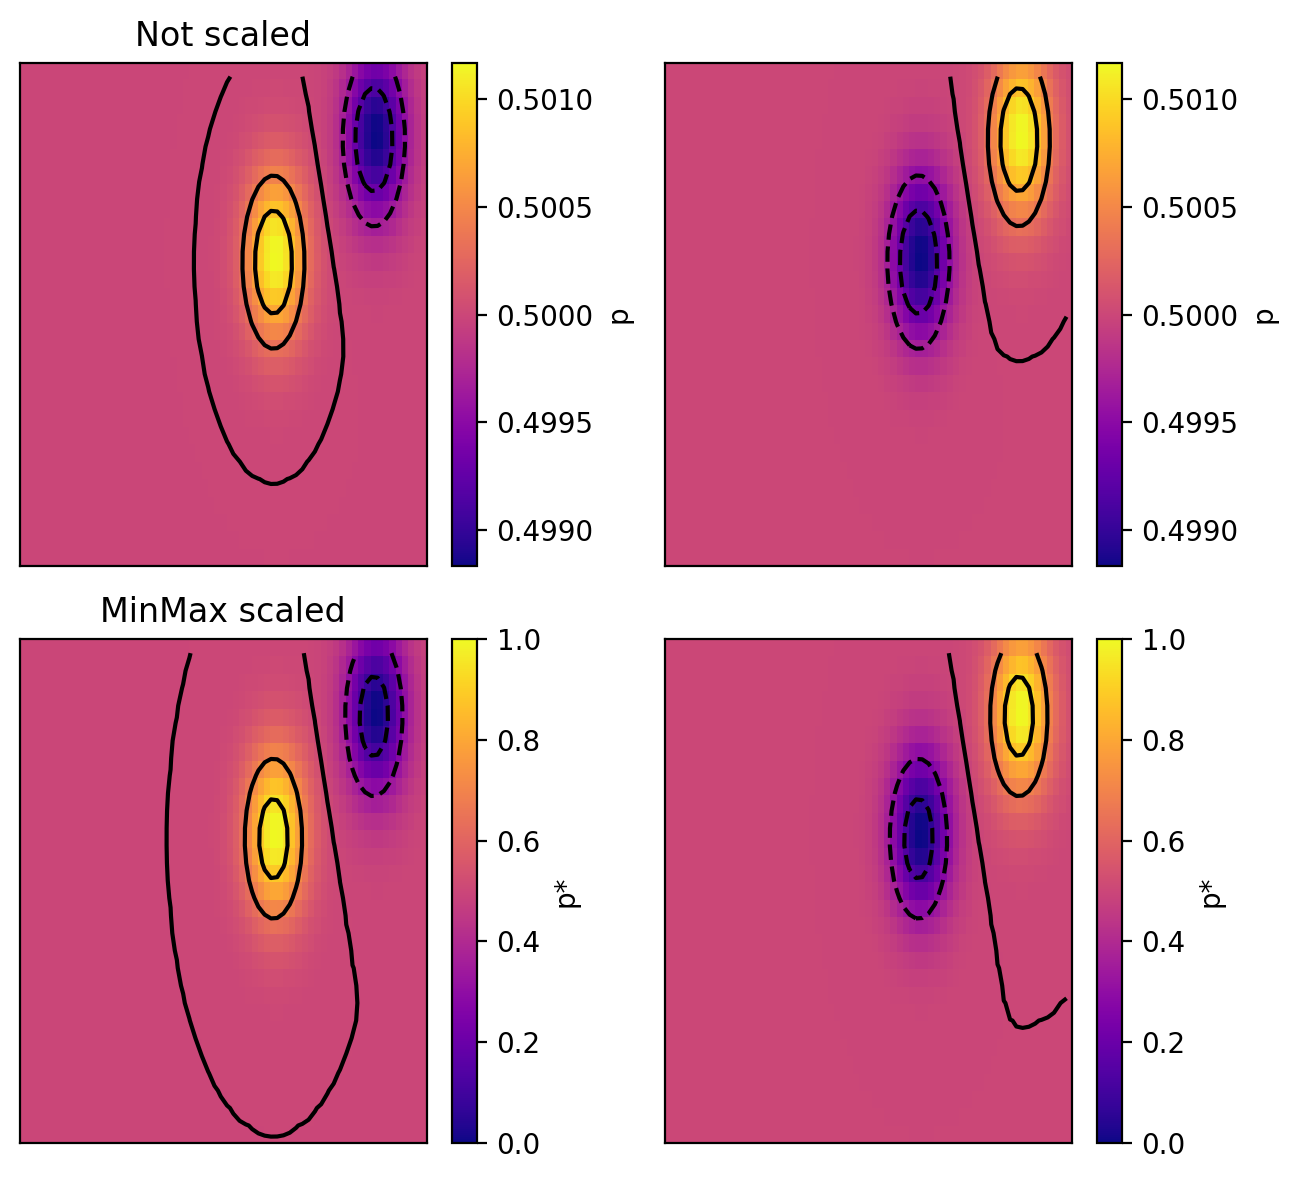

In [44]:
fig, ax = get_axes(4,2)
c=2

for i in range(z.shape[2]):
    surf = ax[i].imshow(z[:,:,i], extent=(x_min, x_max, y_min, y_max),
                cmap='plasma',
                origin="lower", aspect='auto')
    cbar = fig.colorbar(surf,ax=ax[i], label='p')
    ax[i].contour(xx, yy, z[:,:,i]-.500001, levels=5, colors='0.', norm='linear', zorder=4)


for i in range(z_scaled.shape[2]):
    surf = ax[i+c].imshow(z_scaled[:,:,i], extent=(x_min, x_max, y_min, y_max),
                cmap='plasma',
                origin="lower", aspect='auto')
    cbar = fig.colorbar(surf,ax=ax[i+c], label='p*')
    ax[i+c].contour(xx, yy, z_scaled[:,:,i]-.500001, levels=5, colors='0.', norm='linear', zorder=4)

ax[0].set_title('Not scaled')
ax[2].set_title('MinMax scaled')

for i in range(4):
    ax[i].set_xticks(())
    ax[i].set_yticks(())

fig.tight_layout()

In [45]:
H = scipy.stats.entropy(pk=Z, axis=1)
H_scaled = scipy.stats.entropy(pk=Z_scaled, axis=1)

<bound method Figure.tight_layout of <Figure size 1320x600 with 2 Axes>>

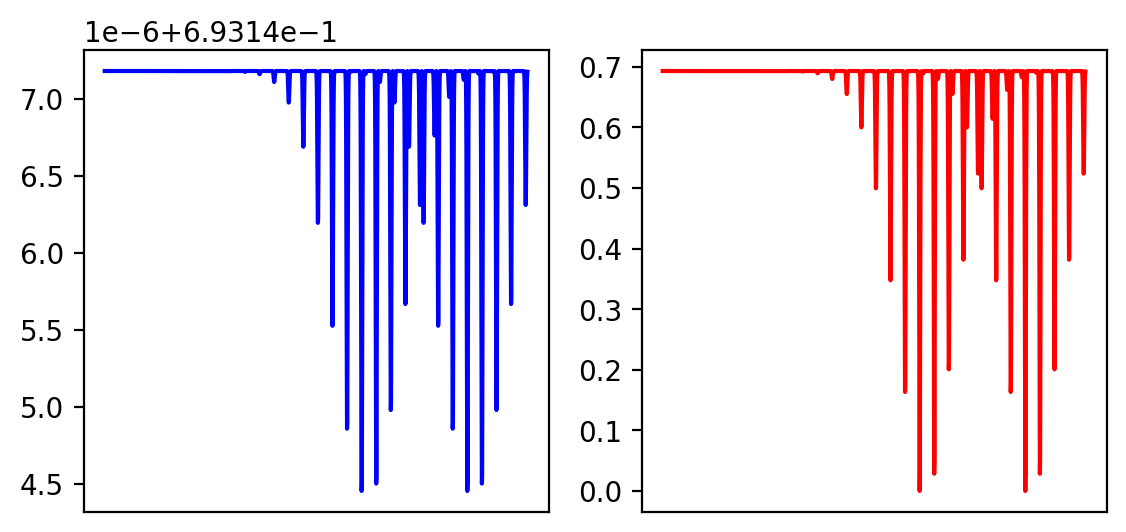

In [46]:
fig, ax = get_axes(2,2)

ax[0].plot(H, c='b', alpha=1)
ax[1].plot(H_scaled, c='r', alpha=1)

for i in range(2):
    ax[i].set_xticks(())

fig.tight_layout